In [1]:
! pip install pandas numpy matplotlib

  Using cached pandas-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)


In [2]:
! pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 458.1 kB/s eta 0:00:0000:0100:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 466.6 kB/s eta 0:00:0000:0100:02
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [3]:
! pip install xgboost

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import LabelEncoder


In [5]:
df = pd.read_csv('municipality_bus_utilization.csv')

In [6]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [7]:
df1 = df.copy()

In [8]:
df1

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [9]:
# df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [10]:
# df1.info()

In [11]:
df1['date'] = pd.to_datetime(df1['timestamp']).dt.date
df1['hour'] = pd.to_datetime(df1['timestamp']).dt.hour

In [12]:
# data = df1.set_index('timestamp', drop=True)

In [13]:
# data = data.groupby(['municipality_id']).resample('H').bfill()

In [14]:
df_interpolated = df1.groupby(['date', 'municipality_id']).apply(lambda group: group.interpolate(method='polynomial', order=2, limit_direction='both'))

In [15]:
# data1 = data.droplevel(level=0)

In [16]:
# data1

In [17]:
df_interpolated = df_interpolated.droplevel(0)

In [18]:
df_interpolated

timestamp  municipality_id  usage  \
municipality_id                                                      
0               3      2017-06-04 07:59:42                0    204   
                18     2017-06-04 08:25:42                0    247   
                29     2017-06-04 08:59:42                0    332   
                34     2017-06-04 09:32:46                0    429   
                47     2017-06-04 09:59:48                0    485   
...                                    ...              ...    ...   
9               13021  2017-08-19 14:30:33                9    983   
                13035  2017-08-19 15:03:34                9    976   
                13040  2017-08-19 15:29:33                9    954   
                13054  2017-08-19 16:03:35                9    879   
                13063  2017-08-19 16:30:35                9    815   

                       total_capacity        date  hour  
municipality_id                                          
0               3                2813  2017-06-04     7  
                18               2813  2017-06-04     8  
                29               2813  2017-06-04     8  
                34               2813  2017-06-04     9  
                47               2813  2017-06-04     9  
...                               ...         ...   ...  
9               13021            1332  2017-08-19    14  
                13035            1332  2017-08-19    15  
                13040            1332  2017-08-19    15  
                13054            1332  2017-08-19    16  
                13063            1332  2017-08-19    16  

[13070 rows x 6 columns]

In [19]:
df_interpolated = df_interpolated.droplevel(0)

In [20]:
df_hourly = df_interpolated.groupby(['date','municipality_id', 'hour'])['usage'].mean().reset_index()

In [21]:
df_hourly

,date,municipality_id,hour,usage
0,2017-06-04,0,7,204.0
1,2017-06-04,0,8,289.5
2,2017-06-04,0,9,457.0
3,2017-06-04,0,10,558.5
4,2017-06-04,0,11,605.5
...,...,...,...,...
6735,2017-08-19,9,12,825.0
6736,2017-08-19,9,13,918.5
6737,2017-08-19,9,14,981.0
6738,2017-08-19,9,15,965.0


In [22]:

train_data = df_hourly[df_hourly['date'] < pd.to_datetime('2017-08-05').date()]
test_data = df_hourly[df_hourly['date'] >= pd.to_datetime('2017-08-05').date()]

In [23]:
baseline_predictions = test_data.groupby(['date', 'municipality_id', 'hour'])['usage'].mean().values
baseline_error = mean_absolute_percentage_error(test_data['usage'].values, baseline_predictions)
baseline_error

0.0

In [24]:
test_data

,date,municipality_id,hour,usage
5320,2017-08-05,0,8,230.5
5321,2017-08-05,0,9,357.5
5322,2017-08-05,0,10,488.5
5323,2017-08-05,0,11,613.0
5324,2017-08-05,0,12,655.0
...,...,...,...,...
6735,2017-08-19,9,12,825.0
6736,2017-08-19,9,13,918.5
6737,2017-08-19,9,14,981.0
6738,2017-08-19,9,15,965.0


In [25]:
train_data['date'] = LabelEncoder().fit_transform(train_data['date'])
test_data['date'] = LabelEncoder().fit_transform(test_data['date'])


/tmp/ipykernel_12900/3399207211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['date'] = LabelEncoder().fit_transform(train_data['date'])
/tmp/ipykernel_12900/3399207211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['date'] = LabelEncoder().fit_transform(test_data['date'])


In [26]:
X_train = train_data.drop(['usage'], axis=1)
y_train = train_data['usage']
X_test = test_data.drop(['usage'], axis=1)

In [27]:
# Using XGBoost

from xgboost import XGBRegressor
xgb_model = XGBRegressor(max_depth=7, n_estimators=5000,  learning_rate=0.05, random_state=2)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_error = mean_absolute_percentage_error(test_data['usage'], xgb_predictions)
xgb_error

0.2653651134648262

In [28]:
# Using Random Forest Regression

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_error = mean_absolute_percentage_error(test_data['usage'], rf_predictions)
rf_error

0.2460996302883329

In [29]:
# Using Gaussian Process Regression

gp_model = GaussianProcessRegressor(kernel=RBF())
gp_model.fit(X_train, y_train)
gp_predictions = gp_model.predict(X_test)
gp_error = mean_absolute_percentage_error(test_data['usage'], gp_predictions)
gp_error

0.2686265366347501

In [30]:
print("Baseline Error: {}".format(baseline_error))
print("XGBoost Error: {}".format(xgb_error))
print("Random Forest Error: {}".format(rf_error))
print("Gaussian Process Regression Error: {}".format(gp_error))


Baseline Error: 0.0
XGBoost Error: 0.2653651134648262
Random Forest Error: 0.2460996302883329
Gaussian Process Regression Error: 0.2686265366347501


In [31]:
Prediction = pd.DataFrame(data=baseline_predictions, columns=['Baseline'])
Prediction['XGBoost'] = xgb_predictions
Prediction['Random Forest'] = rf_predictions
Prediction['Gaussian Process Regressor'] = gp_predictions
Prediction

,Baseline,XGBoost,Random Forest,Gaussian Process Regressor
0,230.5,289.705994,288.360000,289.500000
1,357.5,456.890228,440.796667,457.000000
2,488.5,558.307556,557.566667,558.500000
3,613.0,605.894165,602.051667,605.500000
4,655.0,612.910339,607.416667,613.000000
...,...,...,...,...
1415,825.0,808.284851,787.010000,808.000000
1416,918.5,805.970886,794.365000,806.000000
1417,981.0,782.407837,778.293333,782.000000
1418,965.0,740.649597,722.025000,739.333333


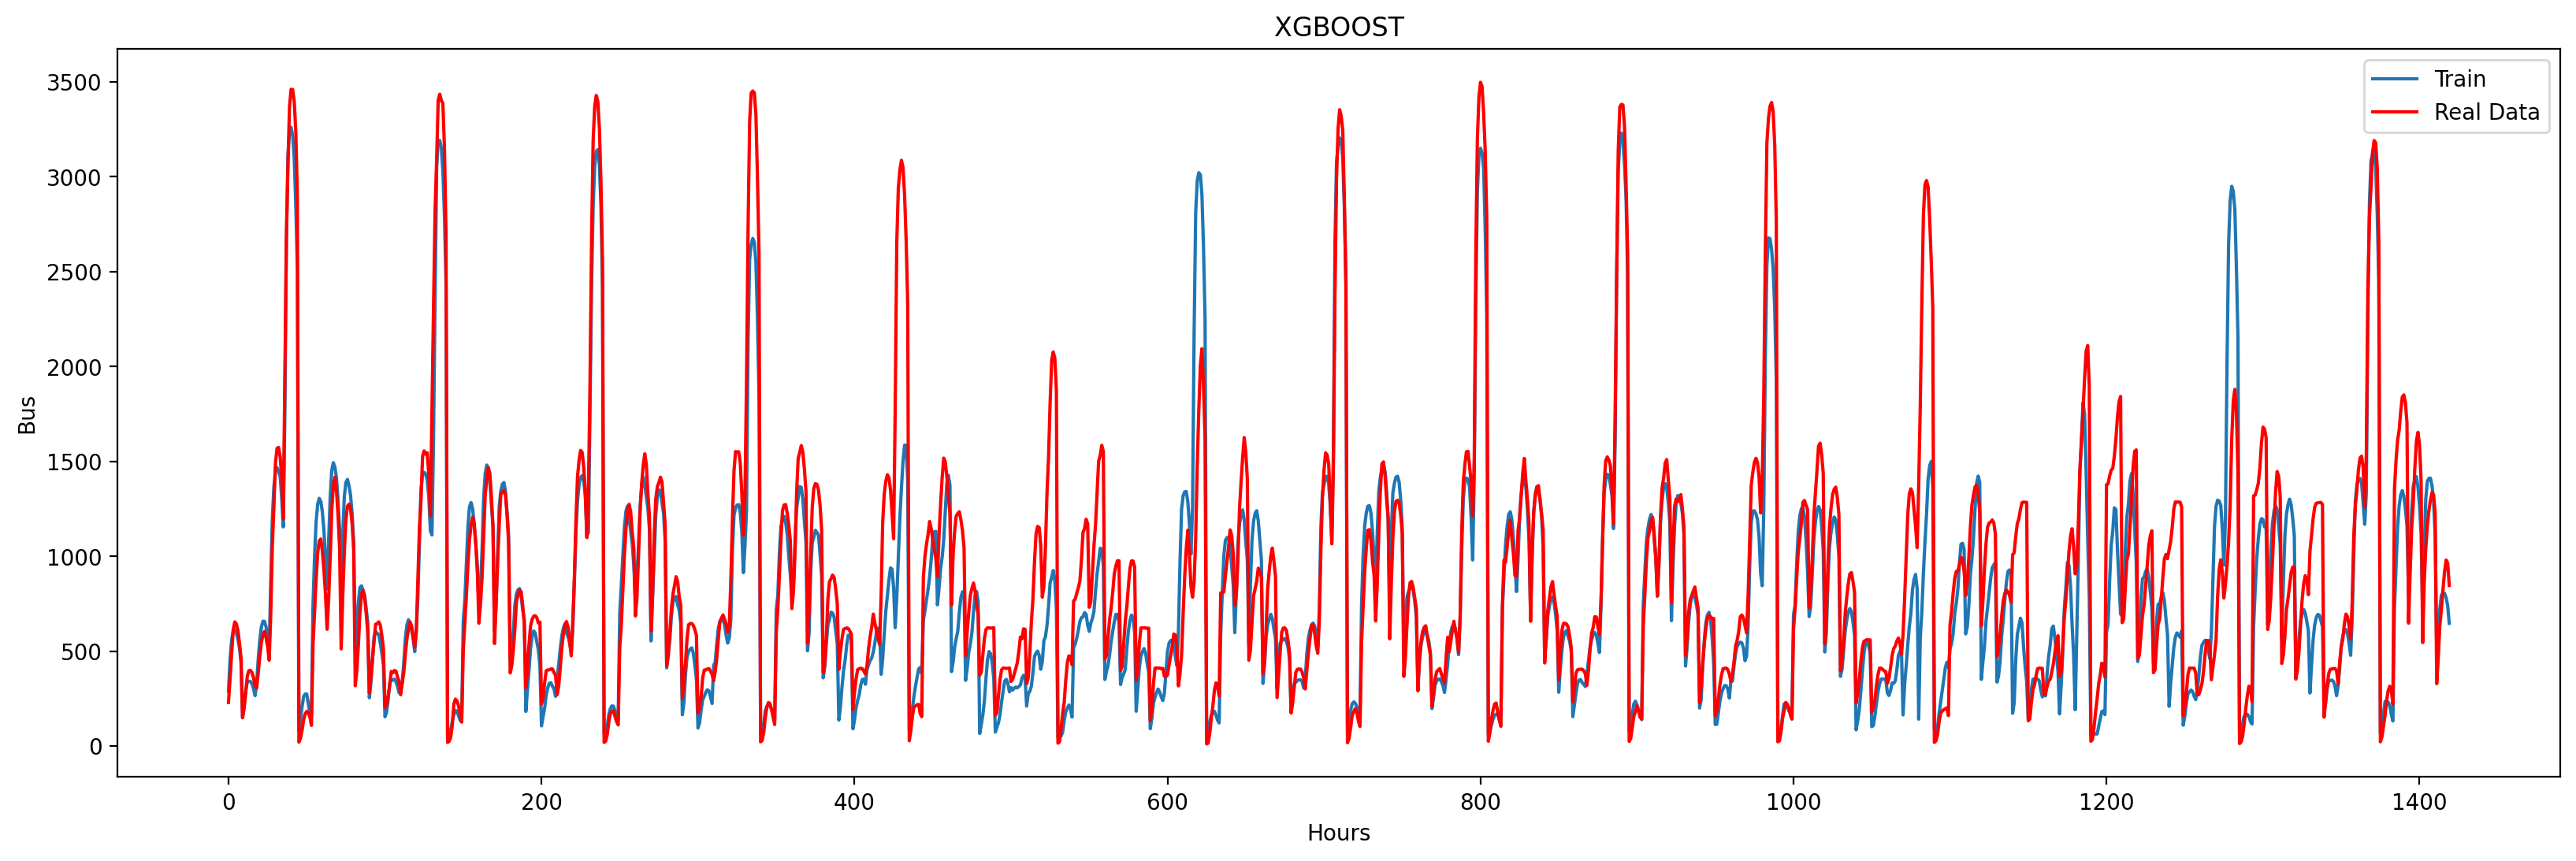

In [34]:
plt.figure(figsize=(20, 6), dpi=200);
plt.plot(Prediction["XGBoost"].index, Prediction["XGBoost"], label='Train')
plt.plot(Prediction["Baseline"].index, Prediction["Baseline"], 'r-', label = 'Real Data')
plt.xlabel('Hours'); plt.ylabel('Bus'); plt.title('XGBOOST'); plt.legend(loc="best")


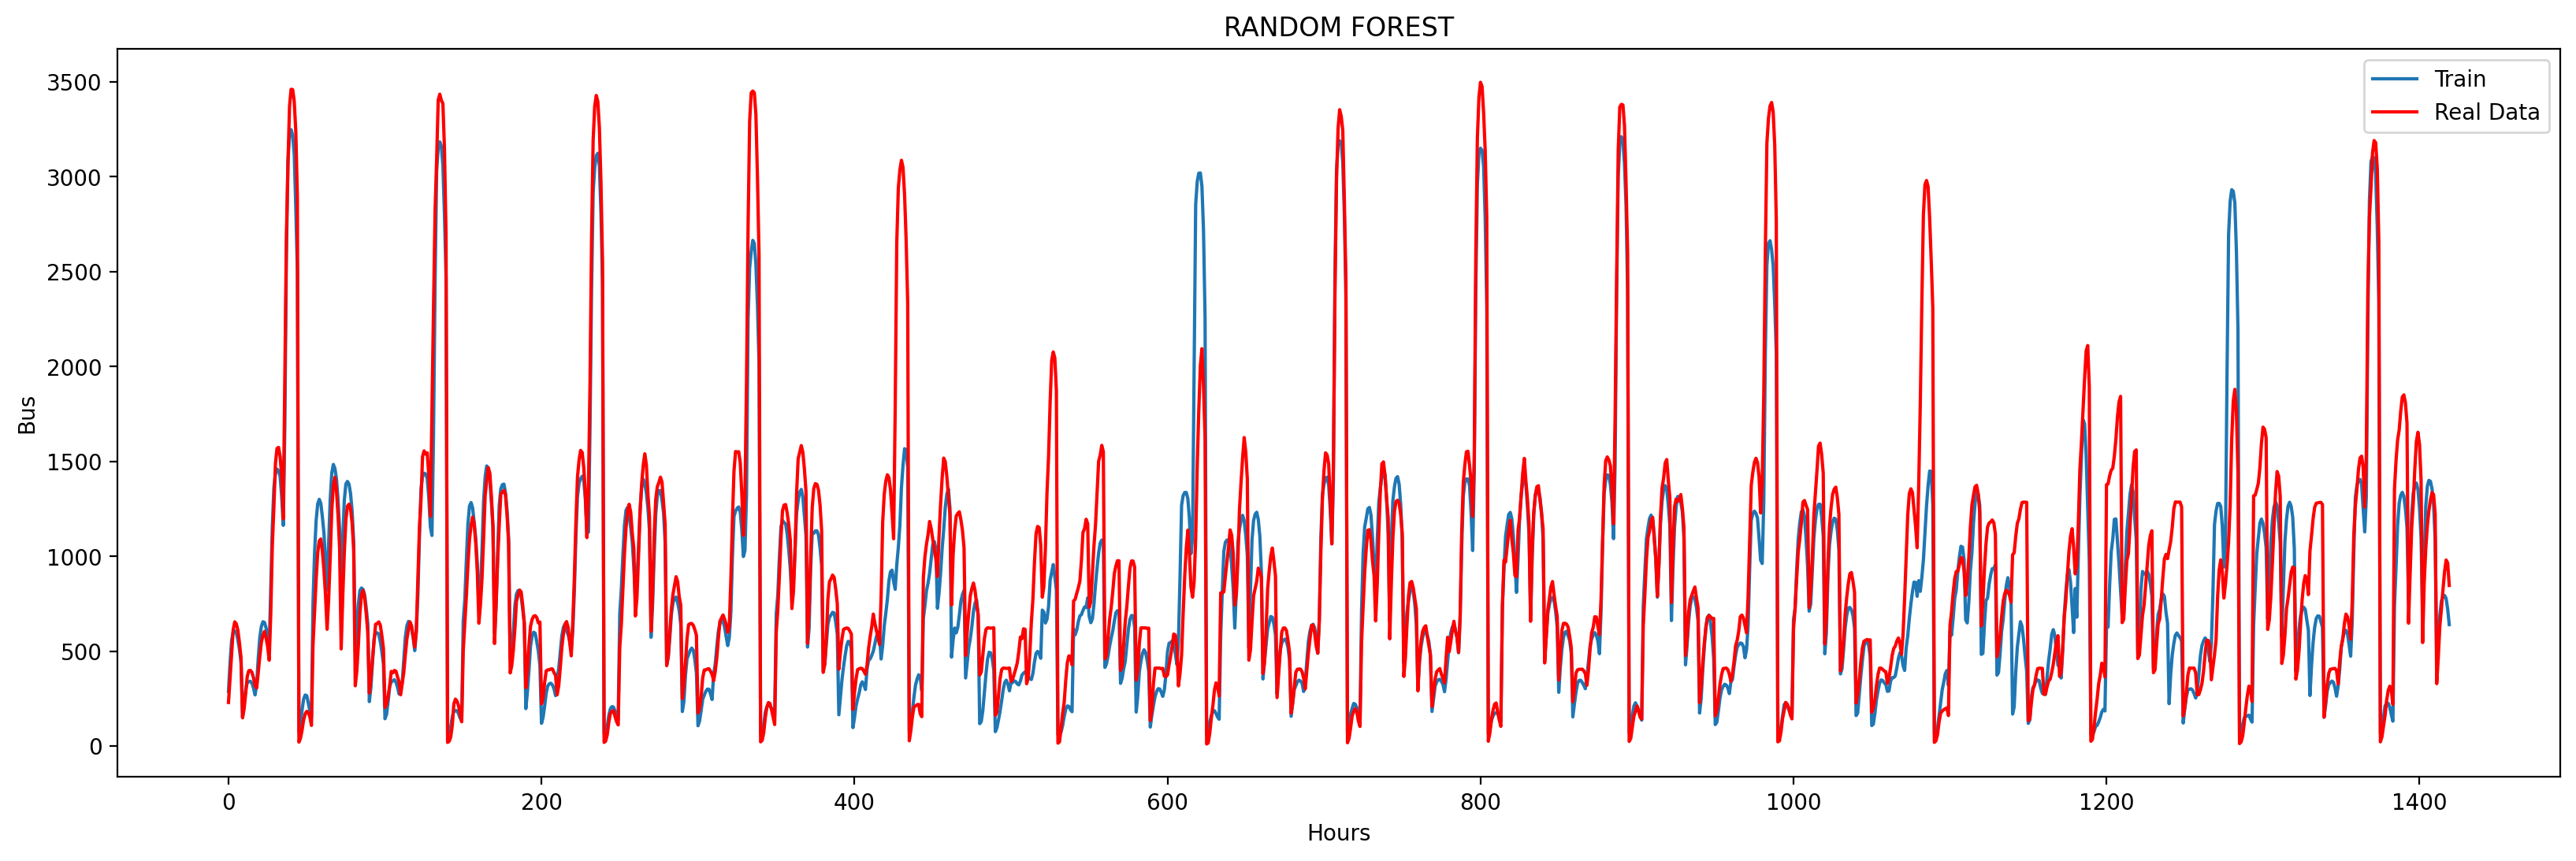

In [35]:
plt.figure(figsize=(20, 6), dpi=200);
plt.plot(Prediction["Random Forest"].index, Prediction["Random Forest"], label='Train')
plt.plot(Prediction["Baseline"].index, Prediction["Baseline"], 'r-', label = 'Real Data')
plt.xlabel('Hours'); plt.ylabel('Bus'); plt.title('RANDOM FOREST'); plt.legend(loc="best")

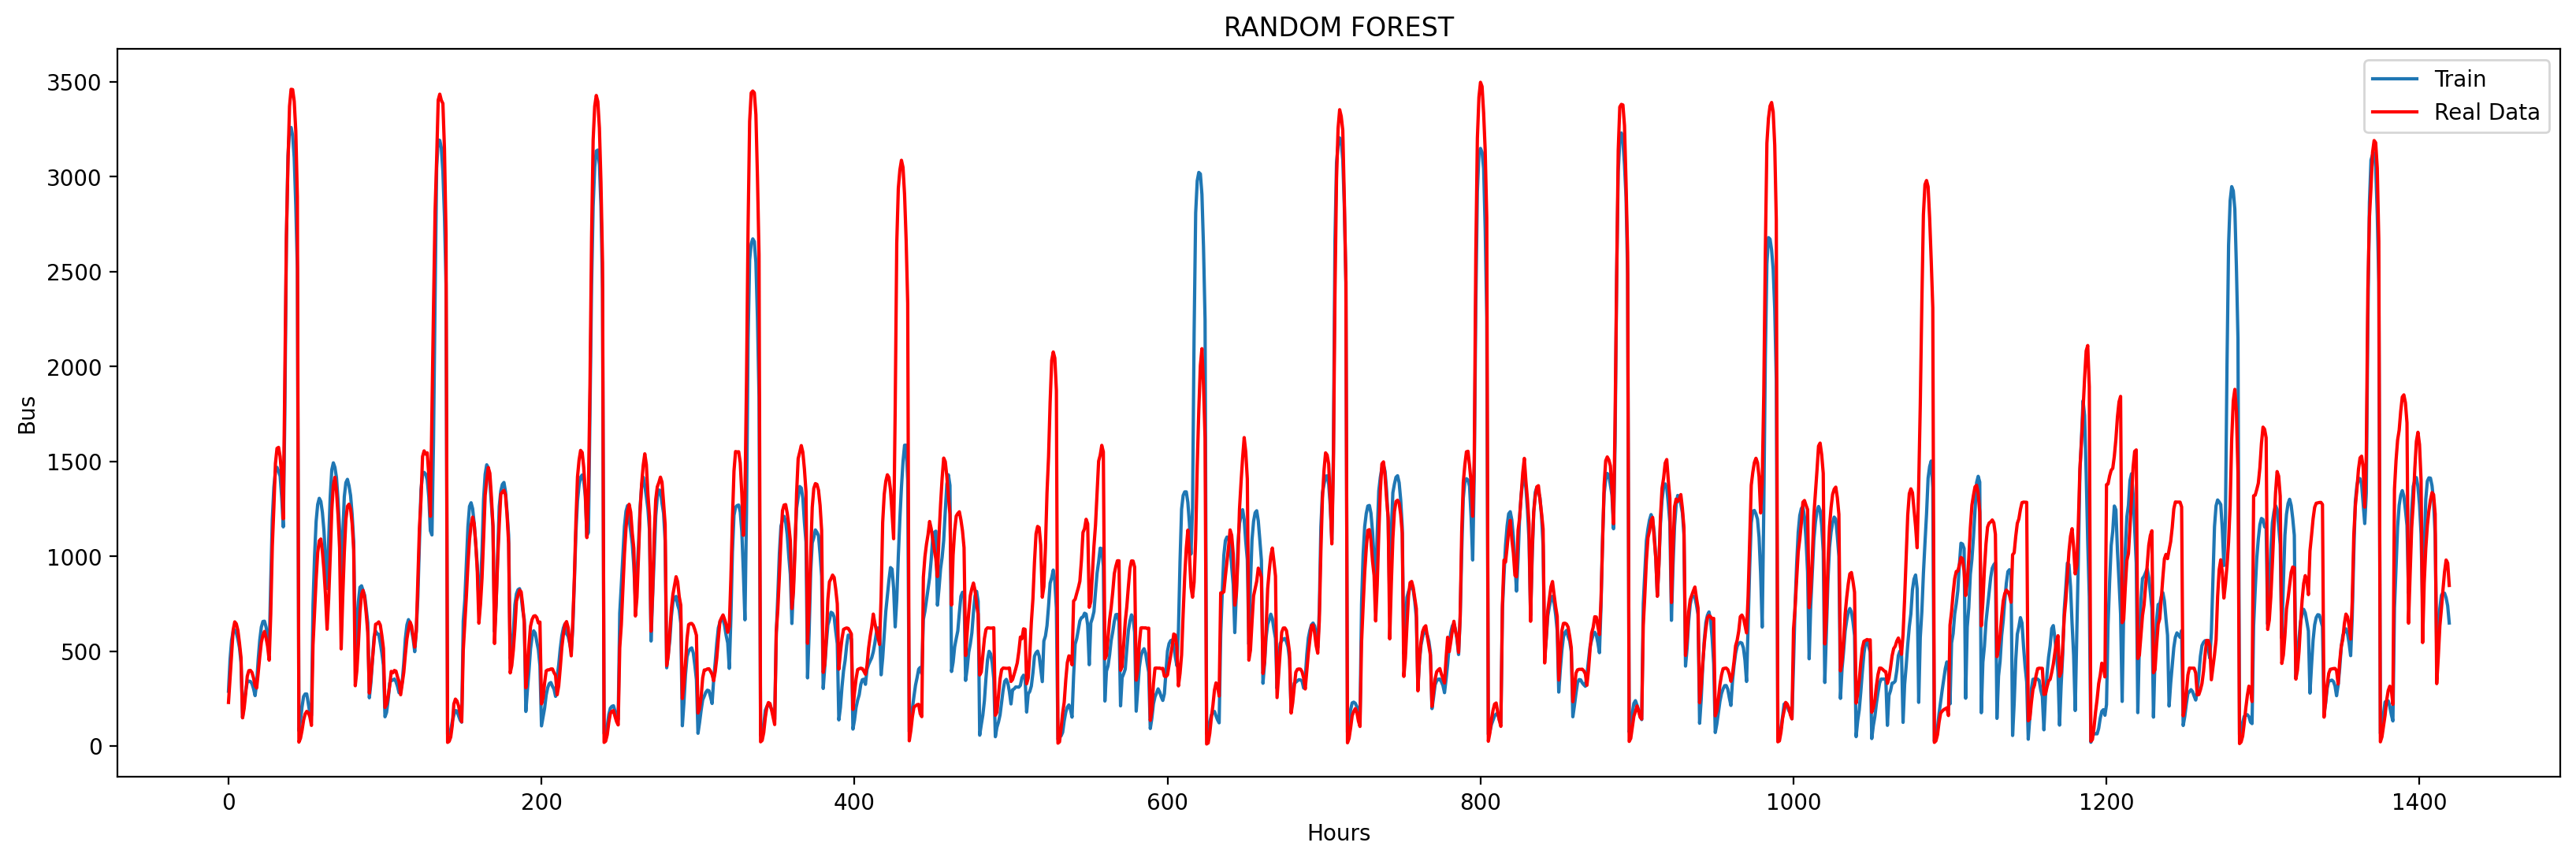

In [36]:
plt.figure(figsize=(20, 6), dpi=200);
plt.plot(Prediction["Gaussian Process Regressor"].index, Prediction["Gaussian Process Regressor"], label='Train')
plt.plot(Prediction["Baseline"].index, Prediction["Baseline"], 'r-', label = 'Real Data')
plt.xlabel('Hours'); plt.ylabel('Bus'); plt.title('RANDOM FOREST'); plt.legend(loc="best")